## Travel Salesman problem
https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html?highlight=linear+program

In [1]:
import qiskit

In [2]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


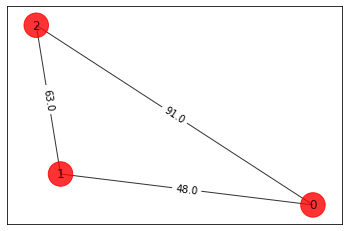

In [3]:
# Generating a graph of 3 nodes
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_matrix(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [16]:
print(tsp._graph.__dict__)

{'graph_attr_dict_factory': <class 'dict'>, 'node_dict_factory': <class 'dict'>, 'node_attr_dict_factory': <class 'dict'>, 'adjlist_outer_dict_factory': <class 'dict'>, 'adjlist_inner_dict_factory': <class 'dict'>, 'edge_attr_dict_factory': <class 'dict'>, 'graph': {}, '_node': {0: {'pos': (68.23518632481435, 5.382101880222267)}, 1: {'pos': (22.03598727726114, 18.43718106986697)}, 2: {'pos': (17.590590108503037, 81.20945066557736)}}, '_adj': {0: {1: {'weight': 48.0}, 2: {'weight': 91.0}}, 1: {0: {'weight': 48.0}, 2: {'weight': 63.0}}, 2: {0: {'weight': 91.0}, 1: {'weight': 63.0}}}, 'add_node': <function frozen at 0x7f8a22d255f0>, 'add_nodes_from': <function frozen at 0x7f8a22d255f0>, 'remove_node': <function frozen at 0x7f8a22d255f0>, 'remove_nodes_from': <function frozen at 0x7f8a22d255f0>, 'add_edge': <function frozen at 0x7f8a22d255f0>, 'add_edges_from': <function frozen at 0x7f8a22d255f0>, 'add_weighted_edges_from': <function frozen at 0x7f8a22d255f0>, 'remove_edge': <function froz

order = (0, 1, 2) Distance = 202.0
Best order from brute force = (0, 1, 2) with total distance = 202.0


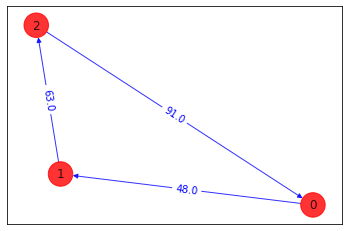

In [4]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

In [5]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [6]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 7581.0
Ising Hamiltonian:
-1282.5 * IIIIIIIIZ
- 1282.5 * IIIIIIIZI
- 1282.5 * IIIIIIZII
- 1268.5 * IIIIIZIII
- 1268.5 * IIIIZIIII
- 1268.5 * IIIZIIIII
- 1290.0 * IIZIIIIII
- 1290.0 * IZIIIIIII
- 1290.0 * ZIIIIIIII
+ 606.5 * IIIIIIIZZ
+ 606.5 * IIIIIIZIZ
+ 606.5 * IIIIIIZZI
+ 606.5 * IIIIIZIIZ
+ 12.0 * IIIIIZIZI
+ 12.0 * IIIIIZZII
+ 12.0 * IIIIZIIIZ
+ 606.5 * IIIIZIIZI
+ 12.0 * IIIIZIZII
+ 606.5 * IIIIZZIII
+ 12.0 * IIIZIIIIZ
+ 12.0 * IIIZIIIZI
+ 606.5 * IIIZIIZII
+ 606.5 * IIIZIZIII
+ 606.5 * IIIZZIIII
+ 606.5 * IIZIIIIIZ
+ 22.75 * IIZIIIIZI
+ 22.75 * IIZIIIZII
+ 606.5 * IIZIIZIII
+ 15.75 * IIZIZIIII
+ 15.75 * IIZZIIIII
+ 22.75 * IZIIIIIIZ
+ 606.5 * IZIIIIIZI
+ 22.75 * IZIIIIZII
+ 15.75 * IZIIIZIII
+ 606.5 * IZIIZIIII
+ 15.75 * IZIZIIIII
+ 606.5 * IZZIIIIII
+ 22.75 * ZIIIIIIIZ
+ 22.75 * ZIIIIIIZI
+ 606.5 * ZIIIIIZII
+ 15.75 * ZIIIIZIII
+ 15.75 * ZIIIZIIII
+ 606.5 * ZIIZIIIII
+ 606.5 * ZIZIIIIII
+ 606.5 * ZZIIIIIII


energy: -7379.0
tsp objective: 202.0
feasible: True
solution: [0, 1, 2]
solution objective: 202.0


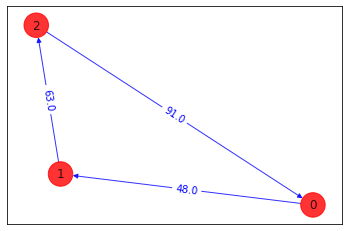

In [7]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

energy: -7326.024699521838
time: 4.687417030334473
feasible: True
solution: [1, 2, 0]
solution objective: 202.0


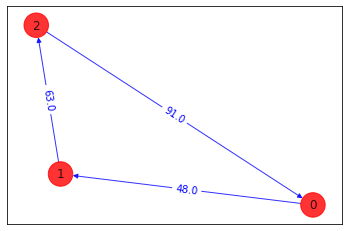

In [8]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [9]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

objective function value: 202.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0
status: SUCCESS
solution: [1, 2, 0]
solution objective: 202.0


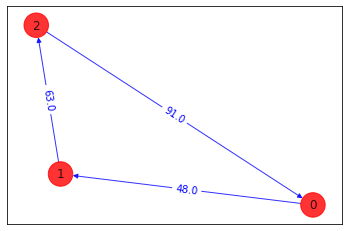

In [10]:
# create minimum eigen optimizer based on VQE
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)